# Facial Emotion Recognition
In this Jupyter Notebook, we will train and test different models and techniques used for Computer Vision applying them in the well-known problem of Facial Emotion Recognition

`Authors`:

                                        Adrián Lorente
                                        Álvaro Morales
                                        Joan Carlos Naftanaila
                                        Lubín Du

## Install && import statements

In [ ]:
# installed = False
# if not installed:
#     # %pip install --upgrade pip
#     # %pip install tensorflow
#     # %pip install tensorflow_datasets
#     # %pip install opencv-python
#     # %pip install matplotlib
#     # %pip install seaborn
#     # %pip instal sklearn
#     # %pip install --upgrade tensorflow

In [1]:
import os
import random
import cv2 as cv
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from matplotlib import colormaps
%matplotlib inline
from tensorflow import keras
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from seaborn import heatmap
from time import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Rescaling
from IPython.display import Image, display

print("Tensorflow version:", tf.__version__)



Tensorflow version: 2.15.0


## Constants declaration

In [2]:
# Paths
cwd = os.getcwd()
TRAIN_PATH = os.path.abspath(os.path.join(cwd, os.pardir + "/dataset/train/"))
TEST_PATH = os.path.abspath(os.path.join(cwd, os.pardir + "/dataset/test/"))
MODELS_PATH = os.path.abspath(os.path.join(cwd, os.pardir + "/models"))
print(MODELS_PATH)
del cwd

# UNCOMMENTING LINE BELOW IS DANGEROUS
#tf.debugging.set_log_device_placement(True)
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("GPU is available!")
    print(tf.config.list_physical_devices('GPU'))
else:
    print("GPU is NOT available!")
# Testing

# print(TRAIN_PATH)
# print(TEST_PATH)

# for dir in os.listdir(TRAIN_PATH):
#     print(dir)

c:\Users\l\Desktop\Universidad\4-curso\1-cuatrimestre\IA-en-las-organizaciones\IAO-Grupo-11\pfinal-fer\models
GPU is NOT available!


### Setting a seed for reproducibility

In [3]:
seed = 10
np.random.seed(seed)
keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.config.experimental.enable_op_determinism()

## Image opening and visualization

--Pixel values vector is--
[[163 128 114 ... 139 141 134]
 [147 114 102 ... 142 138 138]
 [112 106  92 ... 140 141 134]
 ...
 [139 141 136 ... 154 171 191]
 [140 133 120 ... 138 146 158]
 [136 134 113 ... 146 144 144]]
Image has size = (48, 48)


Image reconstruction


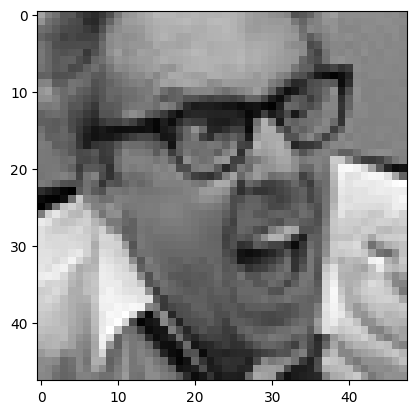

In [4]:
img = cv.imread(TRAIN_PATH + "/angry/Training_3908.jpg", cv.IMREAD_GRAYSCALE)
print("--Pixel values vector is--")
print(img)
print("Image has size = " + str(img.shape))

print("\n")

print("Image reconstruction")
plt.imshow(img, cmap='gray')

## Data loading

In [4]:
# Define a batch size, which will also be used when training the CNN
batch_size = 32 # Default value is 32

# Loading and splitting the train split into train and validation subsets
train, validation = keras.utils.image_dataset_from_directory(directory=TRAIN_PATH, 
                                                 labels="inferred", 
                                                 label_mode="categorical", 
                                                 color_mode="grayscale", 
                                                 batch_size=batch_size,
                                                 image_size=(48, 48), 
                                                 shuffle=True,
                                                 seed=seed,
                                                 validation_split=0.3, 
                                                 subset="both"
                                                )

# This will be used in the final model training
full_train = keras.utils.image_dataset_from_directory(directory=TRAIN_PATH, 
                                                 labels="inferred", 
                                                 label_mode="categorical", 
                                                 color_mode="grayscale", 
                                                 batch_size=batch_size,
                                                 image_size=(48, 48), 
                                                 shuffle=True,
                                                 seed=seed
                                                )


test = keras.utils.image_dataset_from_directory(directory=TEST_PATH,
                                                labels="inferred", 
                                                label_mode="categorical", 
                                                color_mode="grayscale", 
                                                batch_size=batch_size,
                                                image_size=(48, 48), 
                                                shuffle=True,
                                                seed=seed,
                                                validation_split=None)

# Number of target classes
number_of_classes = len(train.class_names)

# Print some information about the datasets
print(train.class_names)
# print(validation.class_names)
print(test.class_names)
# Number of instances of each class in each dataset
print(train.class_names)

# Class dictionary
class_dict = dict(zip(range(len(train.class_names)), train.class_names))
print("Class dictionary: \n", class_dict)

# for images, labels in train.take(1):
#     print("Images shape:", images.shape)


AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)
full_train = full_train.cache().prefetch(buffer_size=AUTOTUNE)


def prepare_augmentation(X: tf.data.Dataset):
    """This function prepares the datasets for data augmentation"""
    # Separate into images (X) and labels (y)
    X_images = X.map(lambda images, labels: images)
    y_labels = X.map(lambda images, labels: labels)
    # Prepare for data augmentation
    X_images = X_images.unbatch()
    y_labels = y_labels.unbatch()
    X_images = np.array(list(X_images.as_numpy_iterator()))
    y_labels = np.array(list(y_labels.as_numpy_iterator()))
    return X_images, y_labels

X_train, y_train = prepare_augmentation(train)

# These will be used for the final model training
X_full_train, y_full_train = prepare_augmentation(full_train)




Found 28709 files belonging to 7 classes.
Using 20097 files for training.
Using 8612 files for validation.
Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class dictionary: 
 {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [7]:
# Checking dataset proportions
# Let's check the class distribution in the train and validation sets
def check_proportions(dataset):
    """Takes a tf.data.dataset object and returns a dictionary 
    with the number of instances of each class in the dataset"""

    dict_count = {
    "angry": 0,
    "disgust": 0,
    "fear": 0,
    "happy": 0,
    "neutral": 0,
    "sad": 0,
    "surprise": 0
    }

    for _, labels in dataset.take(len(dataset)):
        for label in labels:
            # Get the index with the highest value (not one hot encoded)
            value = np.argmax(label, axis=0)
            match (value):
                case 0:
                    dict_count["angry"] += 1
                case 1:
                    dict_count["disgust"] += 1
                case 2:
                    dict_count["fear"] += 1
                case 3:
                    dict_count["happy"] += 1
                case 4:
                    dict_count["neutral"] += 1
                case 5:
                    dict_count["sad"] += 1
                case 6:
                    dict_count["surprise"] += 1
    return dict_count

train_count = check_proportions(train)
val_count = check_proportions(validation)
test_count = check_proportions(test)

# Class proportions
print("Train class proportions (no stratification):")
for value in train_count.values():
    print(value / sum(train_count.values()))

print("-----------------------------------")

print("Validation class proportions (no stratification):")
for value in val_count.values():
    print(value / sum(val_count.values()))

print("-----------------------------------")

print("Test class proportions (no stratification):")
for value in test_count.values():
    print(value / sum(test_count.values()))




print(train_count)
print("-----------------------------------")
print(val_count)
print("-----------------------------------")
print(test_count)

Train class proportions (no stratification):
0.13967258794845003
0.015375429168532616
0.14405135094790267
0.251679355127631
0.17161765437627508
0.1674379260586157
0.11016569637259292
-----------------------------------
Validation class proportions (no stratification):
0.13794705062703205
0.014746864839758476
0.13957268927078495
0.2504644681839294
0.17603344170924293
0.17011147236414306
0.11112401300510916
-----------------------------------
Test class proportions (no stratification):
0.13346336026748398
0.015463917525773196
0.14265812203956535
0.24714405126776262
0.17177486765115632
0.173725271663416
0.11577040958484257
{'angry': 2807, 'disgust': 309, 'fear': 2895, 'happy': 5058, 'neutral': 3449, 'sad': 3365, 'surprise': 2214}
-----------------------------------
{'angry': 1188, 'disgust': 127, 'fear': 1202, 'happy': 2157, 'neutral': 1516, 'sad': 1465, 'surprise': 957}
-----------------------------------
{'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad':

## Stratification

In the previous code, we can see that the dataset is unbalanced because the class "disgust" has very few examples in comparison to the other labels. One of the steps to overcome this issue is usually a stratified split. However, further experimentation showed that the keras.utils.image_dataset_from_directory method actually performed a very similar to a stratified split if asked to subtract a validation split. This method isn't known to stratify the validation split, so we are not sure why this was the case. It might be that the method takes a certain percentage of the samples of each directory to generate the validation split.

Therefore, we will opt to use the splits as they are given by the keras method, since the code for the stratified split is sort of complex and does not really achieve a substantial improvement to the proportions of each class. Anyway, down below, we will show what code was used to stratify the train and validation splits and its resulting proportions.

In [7]:
"""
# Loading and splitting the train split into train and validation subsets
train = keras.utils.image_dataset_from_directory(directory=TRAIN_PATH, 
                                                 labels="inferred", 
                                                 label_mode="categorical", 
                                                 color_mode="grayscale", 
                                                 batch_size=batch_size,
                                                 image_size=(48, 48), 
                                                 shuffle=True,
                                                 seed=seed,
                                                 validation_split=None
                                                #  validation_split=0.3, 
                                                # subset="both"
                                                )
number_of_classes = len(train.class_names)

# For the validation dataset, we need a stratified split
# First, we need to convert the tf.data.dataset objects into a numpy array
data_array = tf.data.Dataset.as_numpy_iterator(train)

images, labels = [], []

for data in data_array:
    images.append(data[0])
    labels.append(np.argmax(data[1], axis=1))

images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)


# train = tf.data.Dataset.from_tensor_slices((images, tf.keras.utils.to_categorical(labels)))

# Stratification is done based on the labels. In this process, batch size is lost
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.3, random_state=seed, stratify=labels)


# Convert the split datasets back to tf.data.dataset objects
train = tf.data.Dataset.from_tensor_slices((train_images, tf.keras.utils.to_categorical(train_labels)))
validation = tf.data.Dataset.from_tensor_slices((val_images, tf.keras.utils.to_categorical(val_labels)))

# Batch the datasets again
train = train.batch(batch_size)
validation = validation.batch(batch_size)

# Let's check the class distribution in the train and validation sets
def check_proportions(dataset):
    # Takes a tf.data.dataset object and returns a dictionary 
    # with the number of instances of each class in the dataset

    dict_count = {
    "angry": 0,
    "disgust": 0,
    "fear": 0,
    "happy": 0,
    "neutral": 0,
    "sad": 0,
    "surprise": 0
    }

    for _, labels in dataset.take(len(dataset)):
        for label in labels:
            # Get the index with the highest value (not one hot encoded)
            value = np.argmax(label, axis=0)
            match (value):
                case 0:
                    dict_count["angry"] += 1
                case 1:
                    dict_count["disgust"] += 1
                case 2:
                    dict_count["fear"] += 1
                case 3:
                    dict_count["happy"] += 1
                case 4:
                    dict_count["neutral"] += 1
                case 5:
                    dict_count["sad"] += 1
                case 6:
                    dict_count["surprise"] += 1
    return dict_count

train_count = check_proportions(train)
val_count = check_proportions(validation)

# Class proportions
print("Train class proportions (with stratification):")
for value in train_count.values():
    print(value / sum(train_count.values()))

print("-----------------------------------")

print("Validation class proportions (with stratification):")
for value in val_count.values():
    print(value / sum(val_count.values()))

"""

'\n# Loading and splitting the train split into train and validation subsets\ntrain = keras.utils.image_dataset_from_directory(directory=TRAIN_PATH, \n                                                 labels="inferred", \n                                                 label_mode="categorical", \n                                                 color_mode="grayscale", \n                                                 batch_size=batch_size,\n                                                 image_size=(48, 48), \n                                                 shuffle=True,\n                                                 seed=seed,\n                                                 validation_split=None\n                                                #  validation_split=0.3, \n                                                # subset="both"\n                                                )\nnumber_of_classes = len(train.class_names)\n\n# For the validation dataset, we need a stratifi

Its resulting output is:

Train class proportions (with stratification):

0.13918192675159236
0.015177149681528663
0.14271496815286625
0.2512937898089172
0.1729199840764331
0.1682424363057325
0.11046974522292993

Validation class proportions (with stratification):

0.1390920701265529
0.015209566933704864
0.1426912806223151
0.25136421688145827
0.1729943109253454
0.16823406478578892
0.11041448972483456

{'angry': 2797, 'disgust': 305, 'fear': 2868, 'happy': 5050, 'neutral': 3475, 'sad': 3381, 'surprise': 2220}

{'angry': 1198, 'disgust': 131, 'fear': 1229, 'happy': 2165, 'neutral': 1490, 'sad': 1449, 'surprise': 951}


As we can see, proportions are very similar to the above cell in which we just use the keras method to perform the split.

## Data augmentation

Data augmentation is a preprocessing technique that introduces variations to the images during the training process. In this case, it will randomly rotate images by 20 degrees or zoom up to 0.2. During fitting, the model will be shown the variations followed by the original image. By doing this, the model will hopefully learn to generalize better. In hindsight, this technique helped improve results by a small margin.

In [30]:
data_aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    fill_mode="nearest"
)

augmented_train = data_aug.flow(x=X_train, y=y_train, batch_size=batch_size, shuffle=False, seed=seed)

full_data_aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    fill_mode="nearest"
)
augmented_full_train = full_data_aug.flow(x=X_full_train, y=y_full_train, batch_size=batch_size, shuffle=False, seed=seed)

# print(augmented_train) 
# for images, labels in augmented_train:
#     print(images.shape)
#     print(images)
#     print(labels.shape)
#     print(labels)
#     break

## Class weight

Another frequent technique when facing an unbalanced dataset is assigning weights to the classes so that classification mistakes on less represented classes will weigh more. This way, the model will learn to classify better these classes, but at the cost of a worse performance on the rest of the classes. For this project, since our goal is not to recognize specifically expressions of disgust, we don't think the trade-off is reasonable, so we will not balance weights. Furthermore, after experimentation, this technique didn't prove to be useful.

In [13]:
from sklearn.utils import class_weight

# We need the labels as a vector
y_train_raw = np.argmax(y_train, axis=1)

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train_raw),
                                                 y = y_train_raw)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.0228001425008906, 1: 9.29126213592233, 2: 0.9917098445595854, 3: 0.5676156583629893, 4: 0.83241519280951, 5: 0.8531946508172362, 6: 1.2967479674796747}


## First basic model

We will be experimenting with this model "made from scratch", in the sense that we won't use any pre-trained model or a well-known architecture like Alex-Net here. Our goal with this is to learn how different layers and hyperparameters influence on the model's performance.

After several experiments, we found out that using padding in the pooling layer yields better results, despite the purpose of pooling (and convolutions in general) is to reduce the dimensions of the input image. However, considering our images are small (48x48 pixels), we think that preserving information through padding is a reasonable approach.

In [31]:
# Model from scratch

model = keras.models.Sequential()

# Layer to standarize the pixel values. (range [0, 1], instead of [0, 255])
model.add(Rescaling(1./255, input_shape=(48, 48, 1)))

model.add(Conv2D(filters=16, kernel_size=(5, 5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding="same"))
# Adding dropout layers increases cells' specialization and prevents overfitting
model.add(Dropout(0.2, seed=seed))


model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Dropout(0.2, seed=seed))


model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Dropout(0.4, seed=seed))

model.add(Conv2D(128, (2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Dropout(0.5, seed=seed))

# Flatten layer to convert the matrix to a vector 
model.add(Flatten())

# MLP starts here
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
# Softmax function returns the probability of each class
model.add(Dense(number_of_classes, activation='softmax'))

# Summary of the model we just created
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 44, 16)        416       
                                                                 
 batch_normalization_8 (Batc  (None, 44, 44, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 44, 44, 16)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 22, 22, 16)       

### Early Stopping

Since CNN can have pretty high execution times, we are going to define an EarlyStopping policy to stop the model's training process once the validation error increases. This allows us to reduce overfitting's risk and to stop without having to execute all epochs, saving us some time. Nonetheless, we could be potentially losing better models by stopping early, though we believe this is acceptable in the stage of creating a basic model.


In [22]:
# EarlyStopping

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2, # It waits for 2 iterations without improvement
    #min_delta=1,
    restore_best_weights=True)
callbacks_list=[early_stopping]

After some exhaustive experimentation, we will stop using the previous EarlyStopping policy to start executing all epochs and setting a checkpoint on the model with the best validation error. This way, we always get the best model after the training process for the specific parameters, at the cost of a slower execution.  

In [32]:
# Checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=MODELS_PATH+'/best_basic.h5',
    monitor='loss',
    save_best_only=True,
    # save_weights_only=True
    )

callbacks_list=[checkpoint]

### Basic model Training

In [33]:
lr = 0.0001
epochs = 300
optimizer = keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer,
              # If labels aren't one hot encoded, use sparse_categorical_crossentropy
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [19]:
start = time()
history = model.fit(
                    augmented_train,
                    epochs=epochs, 
                    validation_data=validation,
                    callbacks=callbacks_list,
                    batch_size=batch_size)
end = time()

print(f"Training took {(end - start):.4f} seconds")

# This output is from the extreme test (1000 epochs)

Epoch 1/1000
629/629 [==============================] - 12s 19ms/step - loss: 2.0068 - accuracy: 0.1969 - val_loss: 1.8220 - val_accuracy: 0.2261
Epoch 2/1000
629/629 [==============================] - 11s 18ms/step - loss: 1.9142 - accuracy: 0.2103 - val_loss: 1.8025 - val_accuracy: 0.2579
Epoch 3/1000
629/629 [==============================] - 11s 18ms/step - loss: 1.8841 - accuracy: 0.2192 - val_loss: 1.7946 - val_accuracy: 0.2666
Epoch 4/1000
629/629 [==============================] - 11s 18ms/step - loss: 1.8507 - accuracy: 0.2308 - val_loss: 1.7907 - val_accuracy: 0.2697
Epoch 5/1000
629/629 [==============================] - 11s 18ms/step - loss: 1.8404 - accuracy: 0.2326 - val_loss: 1.7895 - val_accuracy: 0.2759
Epoch 6/1000
629/629 [==============================] - 11s 17ms/step - loss: 1.8224 - accuracy: 0.2330 - val_loss: 1.7856 - val_accuracy: 0.2811
Epoch 7/1000
629/629 [==============================] - 11s 18ms/step - loss: 1.8207 - accuracy: 0.2357 - val_loss: 1.7832 -

In [20]:
# Finding the best epoch from the checkpoint
epochs_stop = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))
print("min val loss: ", np.min(history.history['val_loss']))
final_epoch = epochs_stop[0][0]
print(final_epoch)
print(history.history['loss'][final_epoch])
print(history.history['val_loss'][final_epoch])
print(history.history['accuracy'][final_epoch])
print(history.history['val_accuracy'][final_epoch])

min val loss:  1.0474061965942383
289
1.1140679121017456
1.0474061965942383
0.5775488615036011
0.6118206977844238


### Basic model Training Evaluation

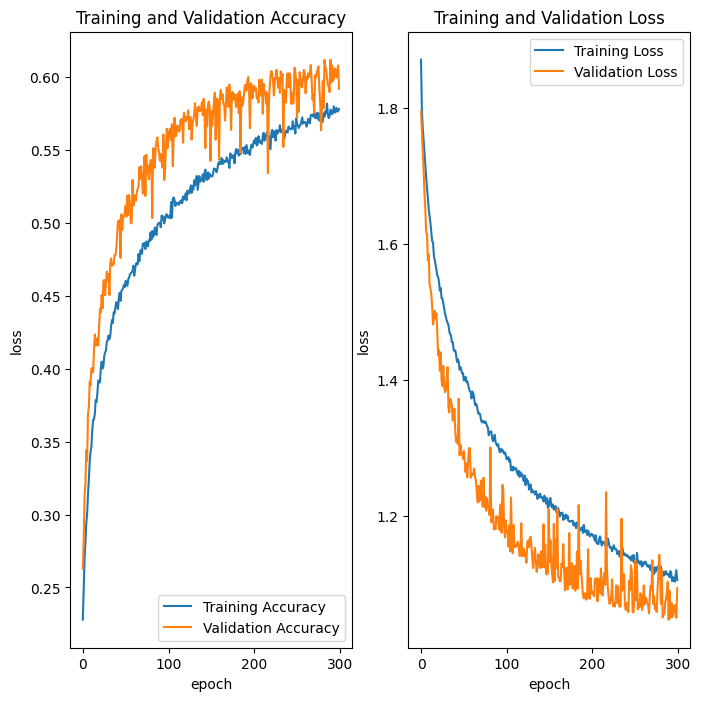

In [ ]:

# EarlyStopping
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Basic model Extreme experiment
After finding our best model, we tried training for 1000 epochs to see if results could be improved with more training, with the following results

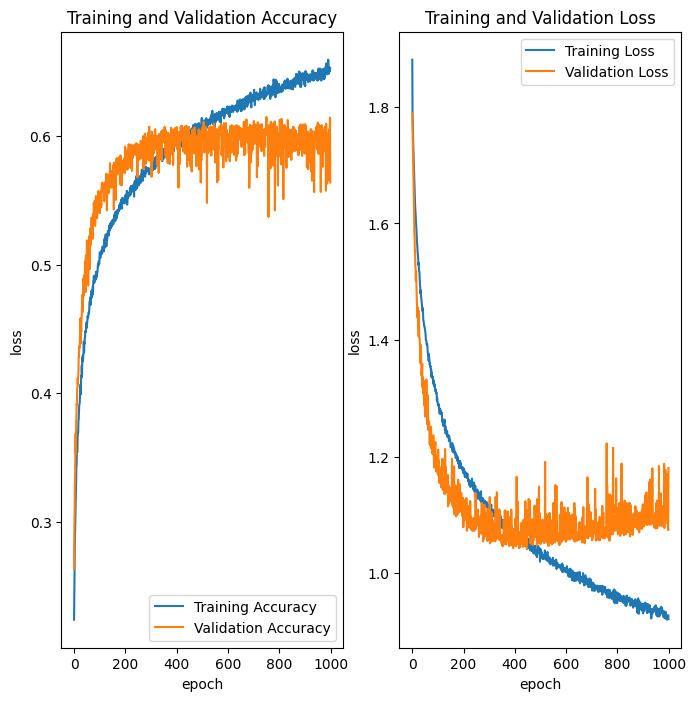

In [13]:

# EarlyStopping
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Basic model Test Evaluation 

Now that the model is trained, we need to evaluate its performance using the test dataset in order to assess its generalization capacity.
Since our output layer had a softmax activation function, predictions will return an array with the probability of each sample belonging to each of the different classes. While this can give relevant information such as the similarity between different expressions (e.g. happy expressions could look similar to neutral ones, hence the neutral class would have a somewhat higher probability), we want to evaluate the performance considering the class with the highest probability as the global prediction.

225/225 [==============================] - 2s 7ms/step
[3 4 3 ... 4 4 3]
[3 2 3 ... 6 4 3]
Accuracy: 0.605461
Confusion matrix:
[[ 464   11   74   74  178  133   24]
 [  42   42    4    5    7    8    3]
 [ 108    3  280   62  215  218  138]
 [  37    5   25 1516  114   44   33]
 [  66    5   29  102  859  153   19]
 [ 119    8   93   91  349  563   24]
 [  22    4   63   46   56   18  622]]
F1 score for each class:
[0.51101322 0.44444444 0.35175879 0.82615804 0.57057456 0.47231544
 0.73435655]


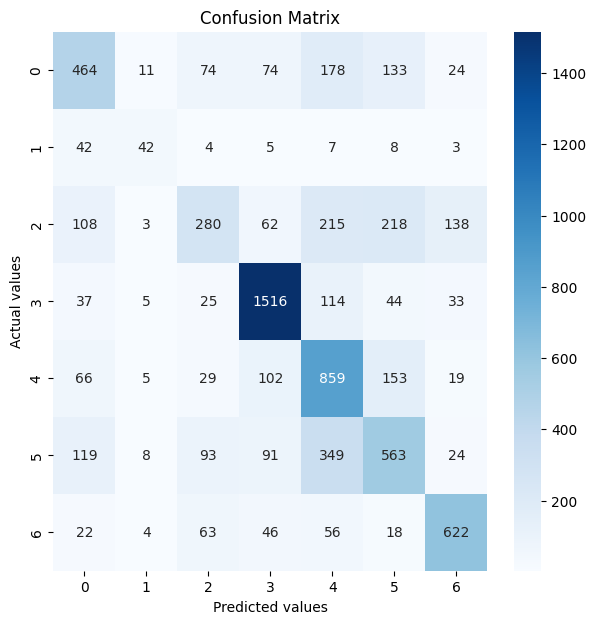

In [22]:
# Import the saved model
basic_model = keras.models.load_model(MODELS_PATH+'/best_basic.h5')

test_pred = basic_model.predict(test) 

# We can keep only the class with the highest probability for each sample
test_pred = np.argmax(test_pred, axis=1)
print(test_pred)
# print(test_pred.shape)

# We need to extract the labels from the test dataset
def extract_labels(dataset):
    labels = []
    for _, label in dataset.unbatch():
        labels.append(label.numpy())
    return np.argmax(labels, axis=1)

test_labels = extract_labels(test)
print(test_labels)

# Accuracy
print(f"Accuracy: {(accuracy_score(test_labels, test_pred)):.6f}")


# Validation Confusion matrix
cf_matrix = confusion_matrix(test_labels, test_pred)
print("Confusion matrix:")
print(cf_matrix)


# F1 score for each class
print("F1 score for each class:")
print(f1_score(test_labels, test_pred, average=None))


# Confusion matrix heatmap
plt.figure(figsize=(7, 7))
heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

## Final basic model

After finding the best model through the previous processes, it's a common practice to fuse the training and validation in a single dataset for a final model fitting. Since we already validated the original model with the validation split, this final model shouldn't have risks of overfitting, and hopefully the extra training samples improve the test results. Note that the CNN architecture and hyperparameters are the exact same as above.

In [41]:
# Model from scratch

model = keras.models.Sequential()

# Layer to standarize the pixel values. (range [0, 1], instead of [0, 255])
model.add(Rescaling(1./255, input_shape=(48, 48, 1)))

model.add(Conv2D(filters=16, kernel_size=(5, 5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding="same"))
# Adding dropout layers increases cells' specialization and prevents overfitting
model.add(Dropout(0.2, seed=seed))


model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Dropout(0.2, seed=seed))


model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Dropout(0.4, seed=seed))

model.add(Conv2D(128, (2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Dropout(0.5, seed=seed))

# Flatten layer to convert the matrix to a vector 
model.add(Flatten())

# MLP starts here
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
# Softmax function returns the probability of each class
model.add(Dense(number_of_classes, activation='softmax'))

# Summary of the model we just created
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 44, 44, 16)        416       
                                                                 
 batch_normalization_12 (Bat  (None, 44, 44, 16)       64        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 44, 44, 16)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 22, 22, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 22, 22, 16)       

In [42]:
# Checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=MODELS_PATH+'/best_basic.h5',
    monitor='loss',
    save_best_only=True,
    # save_weights_only=True
    )

callbacks_list=[checkpoint]

In [ ]:
lr = 0.0001
epochs = 300
optimizer = keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer,
              # If labels aren't one hot encoded, use sparse_categorical_crossentropy
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [34]:
start = time()
history = model.fit(
                    augmented_full_train,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    batch_size=batch_size)
end = time()

print(f"Training took {(end - start):.4f} seconds")               

Epoch 1/300
898/898 [==============================] - 18s 19ms/step - loss: 1.8569 - accuracy: 0.2294
Epoch 2/300
898/898 [==============================] - 16s 18ms/step - loss: 1.7935 - accuracy: 0.2494
Epoch 3/300
898/898 [==============================] - 15s 17ms/step - loss: 1.7660 - accuracy: 0.2699
Epoch 4/300
898/898 [==============================] - 15s 17ms/step - loss: 1.7379 - accuracy: 0.2875
Epoch 5/300
898/898 [==============================] - 15s 17ms/step - loss: 1.7144 - accuracy: 0.3068
Epoch 6/300
898/898 [==============================] - 15s 17ms/step - loss: 1.6881 - accuracy: 0.3246
Epoch 7/300
898/898 [==============================] - 15s 17ms/step - loss: 1.6674 - accuracy: 0.3326
Epoch 8/300
898/898 [==============================] - 15s 17ms/step - loss: 1.6455 - accuracy: 0.3450
Epoch 9/300
898/898 [==============================] - 15s 17ms/step - loss: 1.6332 - accuracy: 0.3532
Epoch 10/300
898/898 [==============================] - 15s 17ms/step - l

In [39]:
epochs_stop = np.where(history.history['loss'] == np.min(history.history['loss']))
print("min val loss: ", np.min(history.history['loss']))
final_epoch = epochs_stop[0][0]
print(final_epoch)
print(history.history['loss'][final_epoch])
print(history.history['accuracy'][final_epoch])

min val loss:  1.0880529880523682
292
1.0880529880523682
0.5856003165245056


### Final basic model Train Evaluation

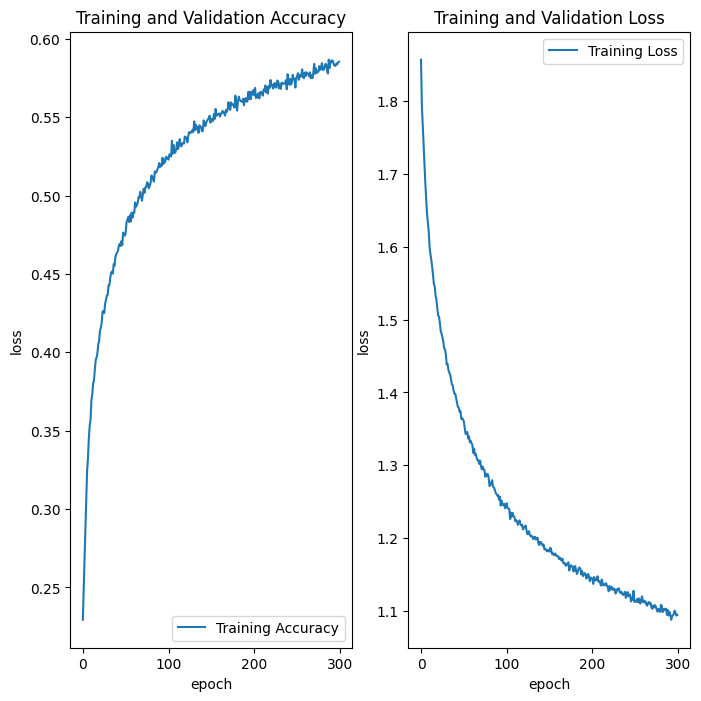

In [35]:

# EarlyStopping
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Final basic model Test Evaluation

225/225 [==============================] - 2s 6ms/step
[3 3 3 ... 4 5 3]
[3 2 3 ... 6 4 3]
Accuracy: 0.619253
Confusion matrix:
[[ 495    9   80   54  147  136   37]
 [  26   57    8    2    7    9    2]
 [ 101    4  342   49  156  223  149]
 [  43    2   31 1494  107   50   47]
 [  71    6   51   85  794  188   38]
 [ 126    4  108   75  301  600   33]
 [  26    3   50   41   33   15  663]]
F1 score for each class:
[0.53629469 0.58163265 0.40377804 0.83603805 0.57163427 0.48622366
 0.73666667]


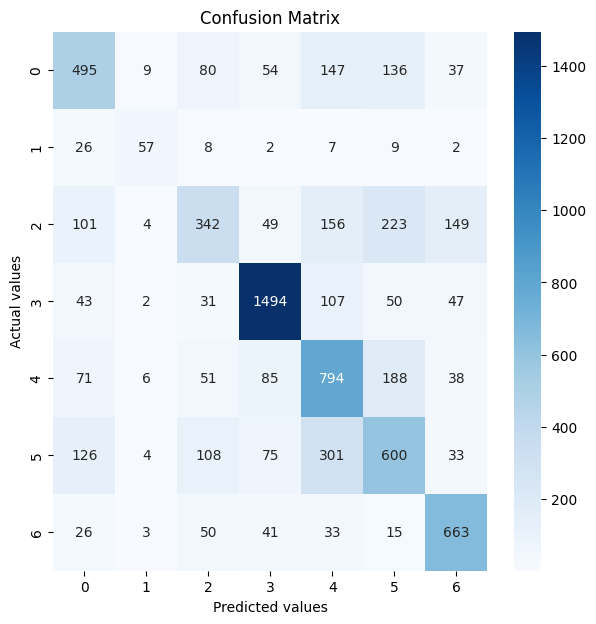

In [40]:
# Import the saved model
basic_model_final = keras.models.load_model(MODELS_PATH+'/best_basic_full_train.h5')

test_pred = basic_model_final.predict(test) 

# We can keep only the class with the highest probability for each sample
test_pred = np.argmax(test_pred, axis=1)
print(test_pred)
# print(test_pred.shape)

# We need to extract the labels from the test dataset
def extract_labels(dataset):
    labels = []
    for _, label in dataset.unbatch():
        labels.append(label.numpy())
    return np.argmax(labels, axis=1)

test_labels = extract_labels(test)
print(test_labels)

# Accuracy
print(f"Accuracy: {(accuracy_score(test_labels, test_pred)):.6f}")


# Validation Confusion matrix
cf_matrix = confusion_matrix(test_labels, test_pred)
print("Confusion matrix:")
print(cf_matrix)


# F1 score for each class
print("F1 score for each class:")
print(f1_score(test_labels, test_pred, average=None))


# Confusion matrix heatmap
plt.figure(figsize=(7, 7))
heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

## Activation map
We thought it would be interesting to see what the model considers most important from each of the input images, which corresponds to the model's activation map.

### Heatmap for the last convolutional layer's activation

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 44, 16)        416       
                                                                 
 batch_normalization_8 (Bat  (None, 44, 44, 16)        64        
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 44, 44, 16)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 22, 22, 16)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 22, 22, 16)       

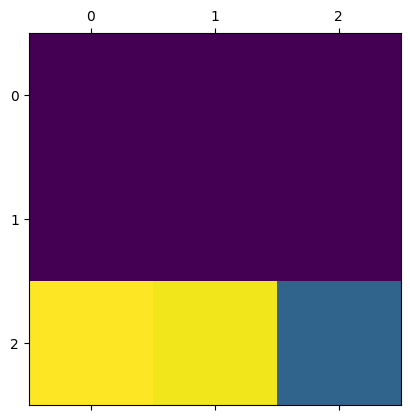

In [62]:
# Load the model
best_model = keras.models.load_model(MODELS_PATH+'/best_basic_final.h5')
best_model.summary()

# We need to get the last convolutional layer
last_conv_layer = best_model.layers[16]

# batch_norm_1 = best_model.layers[2]
# print(batch_norm_1.name)

print(last_conv_layer.name)

def get_img_array(img_path, size):

    # Images are 48x48 pixels size
    img = keras.utils.load_img(img_path, target_size=size, color_mode="grayscale")
    # `array` is a float32 Numpy array of shape (48, 48, 1) 
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 48, 48, 1) #3?
    array = np.expand_dims(array, axis=0) 
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Now, we test it on a sample image
# Remove last layer's softmax
best_model.layers[-1].activation = None

# Print what the top predicted class is
img_path = TEST_PATH + "/happy/PrivateTest_2626531.jpg"
img_array = get_img_array(img_path, size=(48, 48))
# Print what the top predicted class is

# last_conv_layer_model = keras.models.Model(inputs=best_model.input, outputs=last_conv_layer.output)

preds = best_model.predict(img_array)
print(np.argmax(preds, axis=1), class_dict[np.argmax(preds, axis=1)[0]])
# print("Predicted:", extract_labels(preds)[0])

# Generate class activation heatmap
cam_heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer.name)

# Display heatmap
plt.matshow(cam_heatmap)
plt.show()

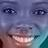

In [63]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, cam_heatmap)

# Transfer Learning
Transfer learning techniques are based on the idea that CNN models that have proved to yield remarkable results could be used on different problems.

## ResNet-50

### ResNet-50 Training

## Converting 1 channel dataset into a 3 channel dataset
Since we are working with grayscale images, we only have one channel. However, most pretrained CNN models expect to receive RGB images, which have 3 channels. In order to address this issue, we will transform our datasets, which will be essentially done by repeating the same image over the 3 channels.

In [32]:
train_transformed = train.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
validation_transformed = validation.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
test_transformed = test.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

# Separate into images (X) and labels (y)
train_unbatch = train.unbatch()
y_train_labels = train.map(lambda images, labels: labels)

train_unbatch_transformed = train_unbatch.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

# Prepare for data augmentation
X_train_transformed = train_unbatch_transformed.map(lambda images, labels: images)
y_train_transformed = train_unbatch_transformed.map(lambda images, labels: labels)

X_train_transformed = np.array(list(X_train_transformed.as_numpy_iterator()))
y_train_transformed = np.array(list(y_train_transformed.as_numpy_iterator()))

# Data augmentation
data_aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    fill_mode="nearest"
)

augmented_train_transformed = data_aug.flow(x=X_train_transformed, y=y_train_transformed, batch_size=batch_size, shuffle=False, seed=seed)


In [122]:
resnet_model = keras.models.Sequential()

pretrained_model= keras.applications.ResNet50(include_top=False,
                   input_shape=(48,48,3),
                   pooling='max', 
                   classes=number_of_classes,
                   weights='imagenet')



for layer in pretrained_model.layers:
        layer.trainable=False


resnet_model.add(pretrained_model)
resnet_model.add(BatchNormalization())
resnet_model.add(Flatten())

resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dropout(0.3, seed=seed))
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dropout(0.3, seed=seed))
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dropout(0.3, seed=seed))
resnet_model.add(Dense(number_of_classes, activation='softmax'))

resnet_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_92 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 flatten_27 (Flatten)        (None, 2048)              0         
                                                                 
 dense_88 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_114 (Dropout)       (None, 2048)              0         
                                                                 
 dense_89 (Dense)            (None, 1024)              2098176   
                                                     

In [98]:
# Checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=MODELS_PATH+'/best_resnetv2.h5',
    monitor='val_loss',
    save_best_only=True)

callbacks_list=[checkpoint]

In [123]:
lr = 0.0001
epochs = 35
optimizer = keras.optimizers.Adam(learning_rate=lr)

resnet_model.compile(optimizer=optimizer,
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

In [124]:
start = time()
history = resnet_model.fit(augmented_train_transformed, 
                    epochs=epochs, 
                    validation_data=validation_transformed,
                    callbacks=callbacks_list,
                    batch_size=batch_size)
end = time()

print(f"Training took {(end - start):.4f} seconds")      

Epoch 1/35
629/629 [==============================] - 29s 42ms/step - loss: 1.7718 - accuracy: 0.3071 - val_loss: 1.5909 - val_accuracy: 0.3891
Epoch 2/35
629/629 [==============================] - 25s 40ms/step - loss: 1.6475 - accuracy: 0.3509 - val_loss: 1.5641 - val_accuracy: 0.4088
Epoch 3/35
629/629 [==============================] - 25s 40ms/step - loss: 1.6086 - accuracy: 0.3692 - val_loss: 1.5375 - val_accuracy: 0.4148
Epoch 4/35
629/629 [==============================] - 25s 40ms/step - loss: 1.5933 - accuracy: 0.3773 - val_loss: 1.5136 - val_accuracy: 0.4176
Epoch 5/35
629/629 [==============================] - 25s 40ms/step - loss: 1.5757 - accuracy: 0.3906 - val_loss: 1.5060 - val_accuracy: 0.4274
Epoch 6/35
629/629 [==============================] - 25s 39ms/step - loss: 1.5564 - accuracy: 0.3995 - val_loss: 1.5037 - val_accuracy: 0.4232
Epoch 7/35
629/629 [==============================] - 25s 40ms/step - loss: 1.5412 - accuracy: 0.4024 - val_loss: 1.5026 - val_accuracy:

In [113]:
epochs_stop = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))
print("min val loss: ", np.min(history.history['val_loss']))
final_epoch = epochs_stop[0][0]
print(final_epoch+1)
print(history.history['loss'][final_epoch])
print(history.history['val_loss'][final_epoch])
print(history.history['accuracy'][final_epoch])
print(history.history['val_accuracy'][final_epoch])

min val loss:  1.4060065746307373
31
1.340038537979126
1.4060065746307373
0.4895755648612976
0.4676033556461334


### ResNet-50 Train Evaluation

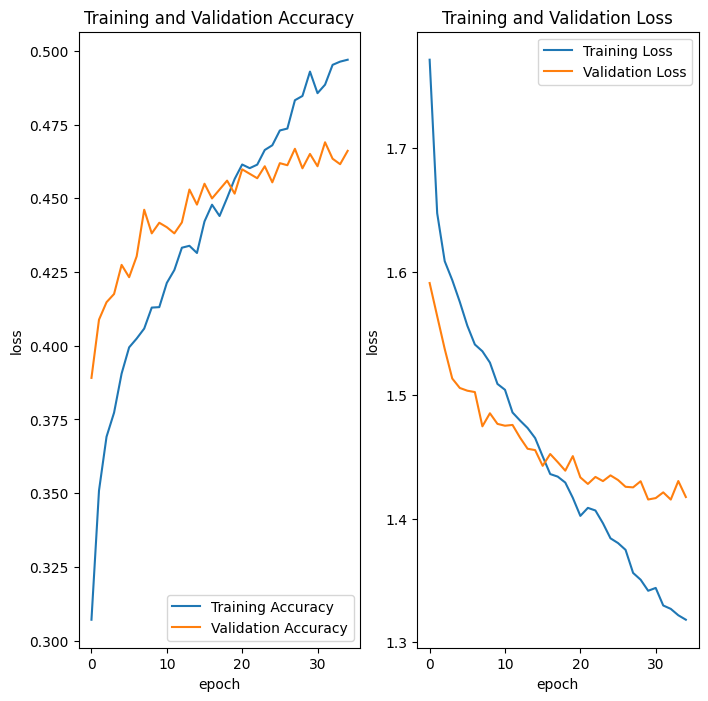

In [126]:
# Import the saved model
resnet_model = keras.models.load_model(MODELS_PATH+'/best_resnet.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### ResNet-50 Test Evaluation

225/225 [==============================] - 5s 18ms/step
[3 2 6 ... 4 0 3]
[3 2 3 ... 6 4 3]
Accuracy: 0.461967
Confusion matrix:
[[ 344    4   89  218  146  111   46]
 [  39   27    2   21   10    5    7]
 [ 158    5  240  197  136  151  137]
 [  97    4   48 1293  164   78   90]
 [ 128    0   79  314  508  132   72]
 [ 200    3  100  304  215  382   43]
 [  46    1   80   93   68   21  522]]
F1 score for each class:
[0.34923858 0.3483871  0.28880866 0.61366872 0.40967742 0.35919135
 0.597254  ]


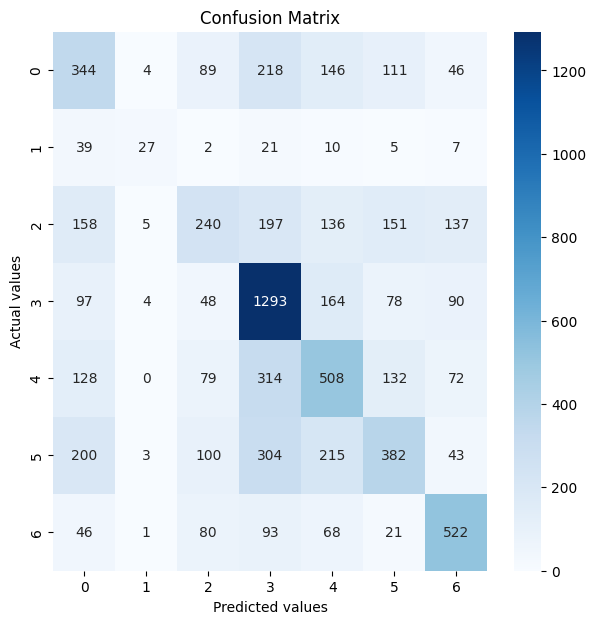

In [127]:
test_pred = resnet_model.predict(test_transformed)


# We can keep only the class with the highest probability for each sample
test_pred = np.argmax(test_pred, axis=1)
print(test_pred)
# print(test_pred.shape)

test_labels = extract_labels(test)
print(test_labels)

# Accuracy
print(f"Accuracy: {(accuracy_score(test_labels, test_pred)):.6f}")

# Confusion matrix
cf_matrix = confusion_matrix(test_labels, test_pred)
print("Confusion matrix:")
print(cf_matrix)

# F1 score for each class
print("F1 score for each class:")
print(f1_score(test_labels, test_pred, average=None))


# Confusion matrix heatmap
plt.figure(figsize=(7, 7))
heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

## EfficientNetV2

### EfficientNet Train

In [33]:
effnet_model = keras.models.Sequential()

pretrained_model= keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False,
                   input_shape=(48,48,3),
                   pooling='max', 
                   classes=number_of_classes,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

effnet_model.add(pretrained_model)

effnet_model.add(Dense(1536, activation='relu'))
effnet_model.add(Dropout(0.3, seed=seed))
effnet_model.add(Dense(768, activation='relu'))
effnet_model.add(Dropout(0.4, seed=seed))
effnet_model.add(Dense(128, activation='relu'))
effnet_model.add(Dropout(0.4, seed=seed))
effnet_model.add(Dense(number_of_classes, activation='softmax'))

effnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 1536)             12930622  
 al)                                                             
                                                                 
 dense_12 (Dense)            (None, 1536)              2360832   
                                                                 
 dropout_15 (Dropout)        (None, 1536)              0         
                                                                 
 dense_13 (Dense)            (None, 768)               1180416   
                                                                 
 dropout_16 (Dropout)        (None, 768)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               98432     
                                                      

In [39]:
# Checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=MODELS_PATH+'/best_effnetv2.h5',
    monitor='val_loss',
    save_best_only=True)

callbacks_list=[checkpoint]

In [36]:
lr = 0.0001
epochs = 50
optimizer = keras.optimizers.Adam(learning_rate=lr)

effnet_model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [37]:
start = time()
history = effnet_model.fit(
                    augmented_train_transformed,
                    epochs=epochs, 
                    validation_data=validation_transformed,
                    callbacks=callbacks_list,
                    batch_size=batch_size)
end = time()

print(f"Training took {(end - start):.4f} seconds")      

Epoch 1/50
629/629 [==============================] - 46s 64ms/step - loss: 1.7573 - accuracy: 0.2940 - val_loss: 1.5874 - val_accuracy: 0.3917
Epoch 2/50
629/629 [==============================] - 40s 64ms/step - loss: 1.6568 - accuracy: 0.3522 - val_loss: 1.5620 - val_accuracy: 0.3942
Epoch 3/50
629/629 [==============================] - 40s 63ms/step - loss: 1.6091 - accuracy: 0.3773 - val_loss: 1.5130 - val_accuracy: 0.4216
Epoch 4/50
629/629 [==============================] - 39s 63ms/step - loss: 1.5870 - accuracy: 0.3832 - val_loss: 1.4958 - val_accuracy: 0.4281
Epoch 5/50
629/629 [==============================] - 39s 63ms/step - loss: 1.5668 - accuracy: 0.3967 - val_loss: 1.4952 - val_accuracy: 0.4359
Epoch 6/50
629/629 [==============================] - 40s 63ms/step - loss: 1.5586 - accuracy: 0.4020 - val_loss: 1.4915 - val_accuracy: 0.4228
Epoch 7/50
629/629 [==============================] - 40s 63ms/step - loss: 1.5399 - accuracy: 0.4044 - val_loss: 1.4580 - val_accuracy:

In [51]:
epochs_stop = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))
print("min val loss: ", np.min(history.history['val_loss']))
final_epoch = epochs_stop[0][0]
print(final_epoch+1)
print(history.history['loss'][final_epoch])
print(history.history['val_loss'][final_epoch])
print(history.history['accuracy'][final_epoch])
print(history.history['val_accuracy'][final_epoch])

min val loss:  1.3015539646148682
29
1.1220542192459106
1.3015539646148682
0.5818778872489929
0.521946132183075


### EfficientNet Test Evaluation

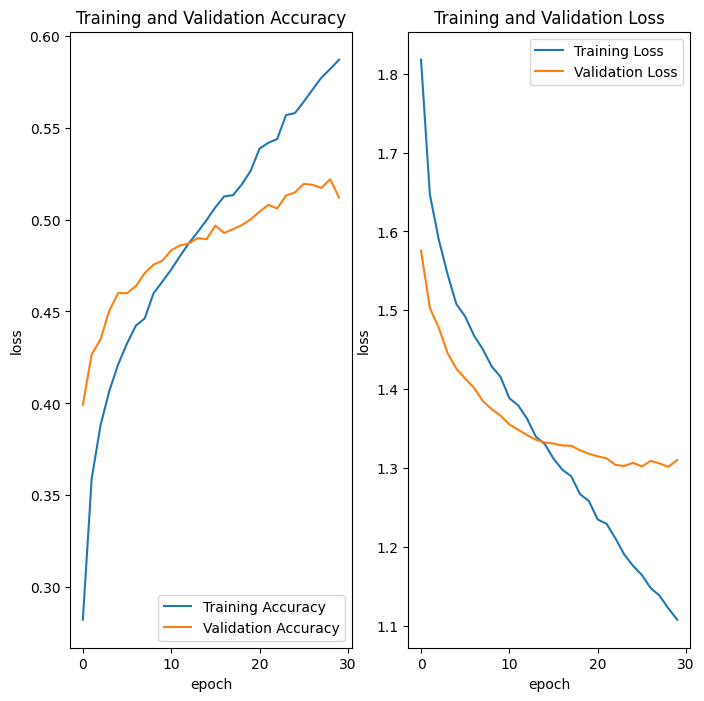

In [52]:
# Import the model if it's saved
effnet_model = keras.models.load_model(MODELS_PATH+'/best_effnet.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### EfficientNet Test evaluation

225/225 [==============================] - 8s 31ms/step
[3 3 3 ... 4 5 4]
[3 2 3 ... 6 4 3]
Accuracy: 0.473112
Confusion matrix:
[[ 294    0  127  255  138  103   41]
 [  27   15   14   28   13   12    2]
 [ 122    1  290  209  166  131  105]
 [  92    1   75 1408  104   56   38]
 [ 105    2   89  337  553   91   56]
 [ 189    2  161  317  218  332   28]
 [  28    0  105  100   68   26  504]]
F1 score for each class:
[0.32396694 0.22727273 0.30769231 0.63595303 0.4436422  0.33233233
 0.62803738]


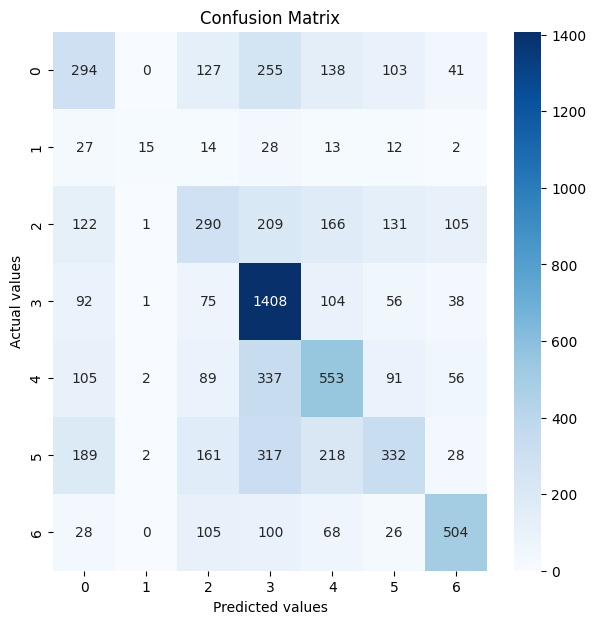

In [53]:
test_pred = effnet_model.predict(test_transformed)


# We can keep only the class with the highest probability for each sample
test_pred = np.argmax(test_pred, axis=1)
print(test_pred)
# print(test_pred.shape)

test_labels = extract_labels(test)
print(test_labels)

# Accuracy
print(f"Accuracy: {(accuracy_score(test_labels, test_pred)):.6f}")

# Confusion matrix
cf_matrix = confusion_matrix(test_labels, test_pred)
print("Confusion matrix:")
print(cf_matrix)

# F1 score for each class
print("F1 score for each class:")
print(f1_score(test_labels, test_pred, average=None))


# Confusion matrix heatmap
plt.figure(figsize=(7, 7))
heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()